In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2023-06-01 10:54:02.624339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 10:54:03.057718: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 10:54:03.060670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 10:54:04.663043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.random.set_seed(43)

# Загрузим данные

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
def plot_samples(images, n_col=4, figsize=(10, 7.5)):
    plt.figure(figsize = figsize)
    for i in range(n_col):
        ax = plt.subplot(3, n_col, i + 1)
        plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.show()

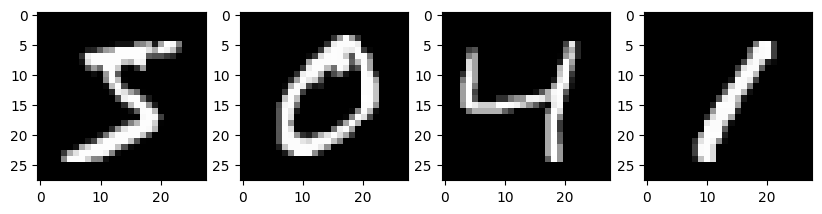

In [6]:
plot_samples(x_train)

# Анализ главных компонент

In [7]:
from sklearn.decomposition import PCA

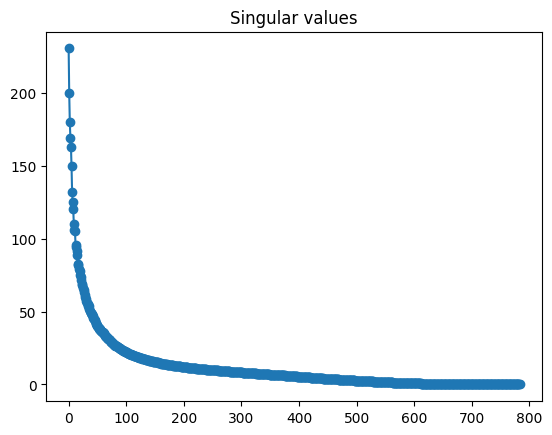

In [8]:
pca = PCA()
pics_pca = pca.fit_transform(x_test.reshape((x_test.shape[0], -1)))
plt.plot(pca.singular_values_, 'o-')
plt.title("Singular values")
plt.show()

In [9]:
def plot_scatter(X, labels, figsize=(15,15)):
    figure = plt.figure(figsize = figsize)
    plt.gca().set_aspect('equal')
    plt.scatter(*X[:,:2].T, c=labels, cmap='tab10')
    plt.colorbar()
    plt.show()

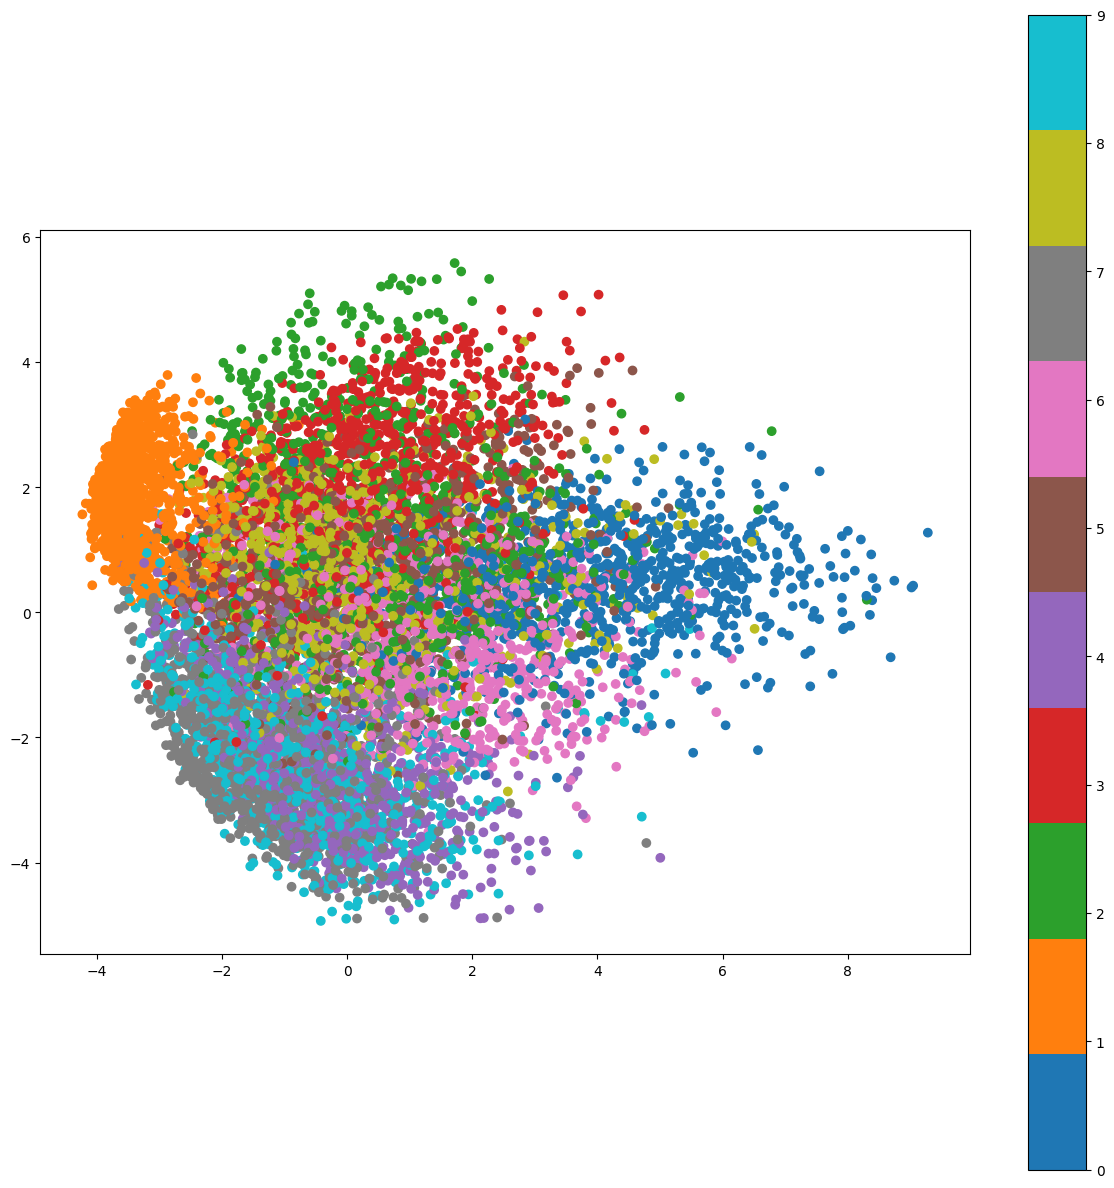

In [10]:
plot_scatter(pics_pca, y_test)

# t-SNE

In [11]:
from sklearn.manifold import TSNE

In [12]:
tsne = TSNE(n_components=2, init='pca')
pics_tsne = tsne.fit_transform(x_test.reshape((x_test.shape[0], -1)))

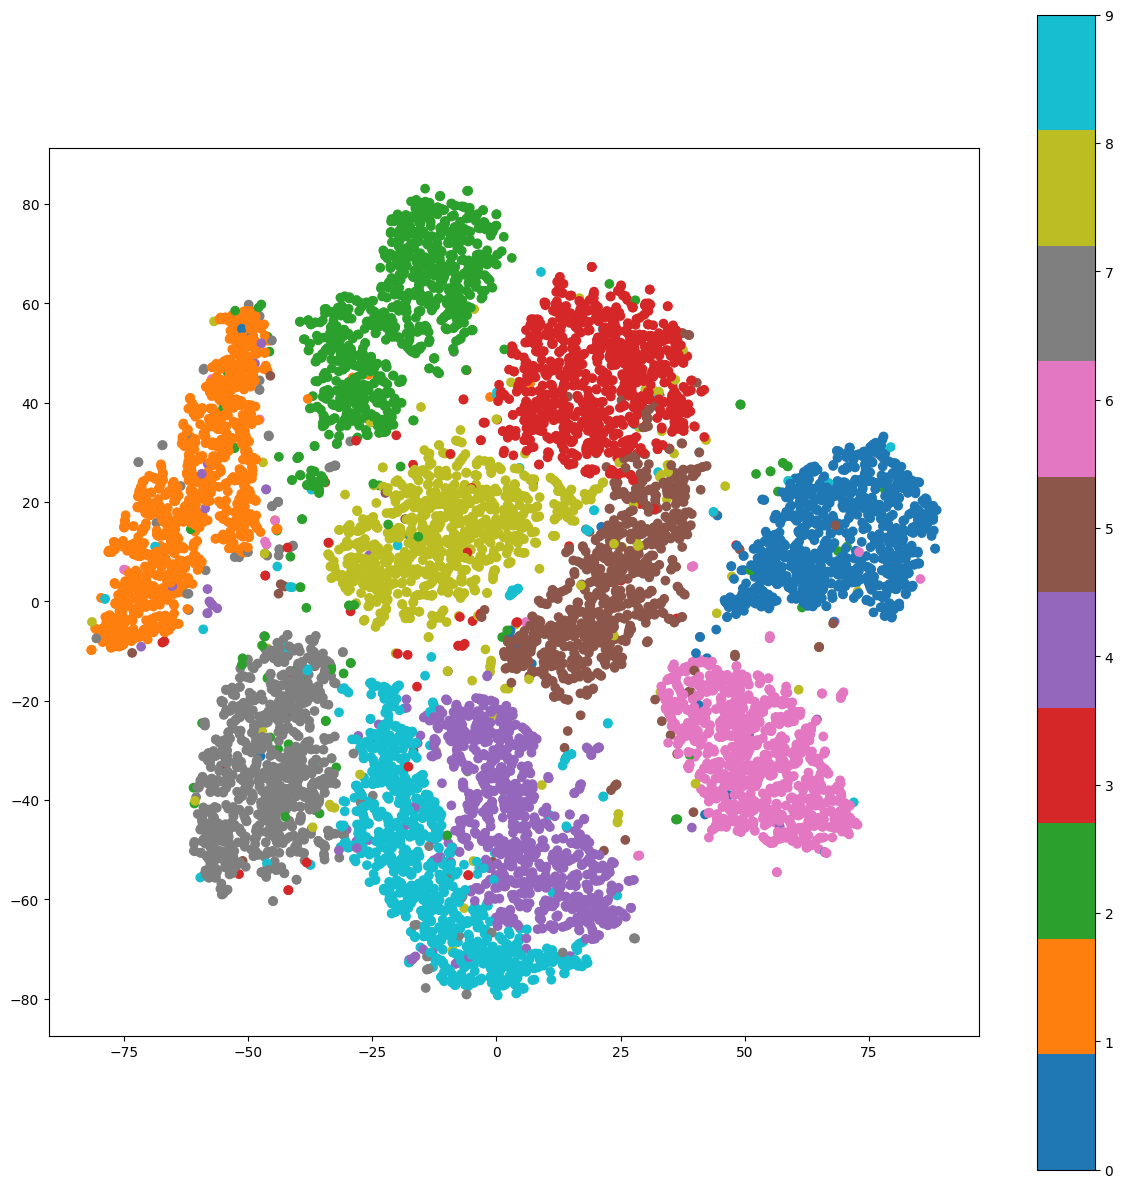

In [13]:
plot_scatter(pics_tsne, y_test)

# Свёрточный автокодировщик

In [14]:
INPUT_SHAPE = (28, 28)
HIDDEN1_CH = 24
HIDDEN2_CH = 36
LATENT_DIM = 8

def get_model():
    inputs = tf.keras.Input(shape=INPUT_SHAPE, name='encoder_input')
    
    encoder = tf.keras.Sequential([
        inputs,
        tf.keras.layers.Reshape((*INPUT_SHAPE, 1)),
        tf.keras.layers.Conv2D(HIDDEN1_CH, (3, 3), strides=(2, 2), activation="relu"),
        tf.keras.layers.Conv2D(HIDDEN2_CH, (3, 3), strides=(2, 2), activation="relu", use_bias=False),
        tf.keras.layers.Conv2D(LATENT_DIM, (6, 6), activation="sigmoid", use_bias=False, name="encoded"),
        tf.keras.layers.Flatten(),
    ])
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Reshape((1, 1, LATENT_DIM)),
        tf.keras.layers.Conv2DTranspose(HIDDEN2_CH, (6, 6), activation="relu", use_bias=False),
        tf.keras.layers.Conv2DTranspose(HIDDEN2_CH, (3, 3), strides=(2, 2), activation="relu", use_bias=False),
        tf.keras.layers.Conv2DTranspose(HIDDEN1_CH, (4, 4), strides=(2, 2), activation="relu", use_bias=False),
        tf.keras.layers.Conv2DTranspose(1, (1, 1), activation="sigmoid", use_bias=False),
        tf.keras.layers.Reshape(INPUT_SHAPE),
    ])

    autoencoder = tf.keras.Model(inputs=inputs, outputs=decoder(encoder(inputs)))
    
    return autoencoder, encoder, decoder

model, encoder, decoder = get_model()

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 sequential (Sequential)     (None, 8)                 18384     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            35896     
                                                                 
Total params: 54,280
Trainable params: 54,280
Non-trainable params: 0
_________________________________________________________________


In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(1000).batch(4)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test)).shuffle(1000).batch(4)

learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='MSE')

fit = model.fit(train_dataset, epochs=25, validation_data=test_dataset)

Epoch 1/25


2023-06-01 10:55:09.856538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60000,28,28]
	 [[{{node Placeholder/_0}}]]


14995/15000 [============================>.] - ETA: 0s - loss: 0.0273

2023-06-01 10:56:27.146447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [10000,28,28]
	 [[{{node Placeholder/_0}}]]


15000/15000 [==============================] - 83s 5ms/step - loss: 0.0273 - val_loss: 0.0236
Epoch 2/25
15000/15000 [==============================] - 86s 6ms/step - loss: 0.0228 - val_loss: 0.0223
Epoch 3/25
15000/15000 [==============================] - 83s 6ms/step - loss: 0.0219 - val_loss: 0.0221
Epoch 4/25
15000/15000 [==============================] - 84s 6ms/step - loss: 0.0214 - val_loss: 0.0215
Epoch 5/25
15000/15000 [==============================] - 83s 6ms/step - loss: 0.0210 - val_loss: 0.0213
Epoch 6/25
15000/15000 [==============================] - 86s 6ms/step - loss: 0.0208 - val_loss: 0.0209
Epoch 7/25
15000/15000 [==============================] - 85s 6ms/step - loss: 0.0206 - val_loss: 0.0209
Epoch 8/25
15000/15000 [==============================] - 77s 5ms/step - loss: 0.0204 - val_loss: 0.0209
Epoch 9/25
15000/15000 [==============================] - 82s 5ms/step - loss: 0.0203 - val_loss: 0.0205
Epoch 10/25
15000/15000 [==============================] - 81s 5ms

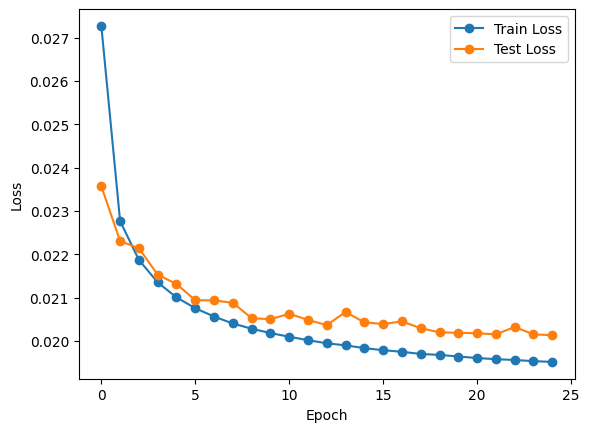

In [17]:
plt.plot(fit.history['loss'], '-o', label="Train Loss")
plt.plot(fit.history['val_loss'], '-o', label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

In [18]:
def plot_encoded(encoded, n_col=4, figsize=(10, 7.5)):
    plt.figure(figsize = figsize)
    for i in range(n_col):
        ax = plt.subplot(3, n_col, i + 1)
        e = encoded[i].reshape(-1)
        plt.bar(np.arange(e.shape[0]), e)
    plt.show()

313/313 [==============================] - 2s 7ms/step


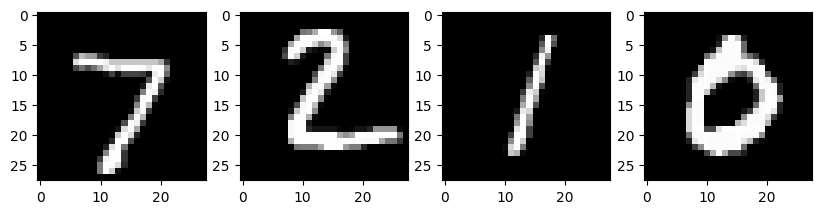

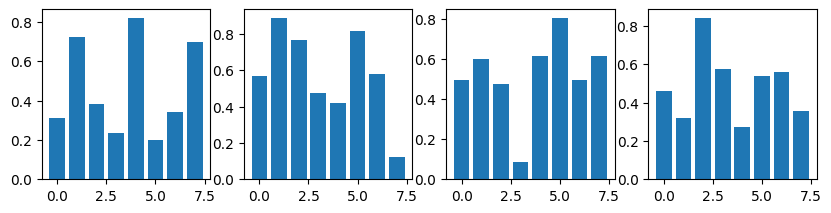

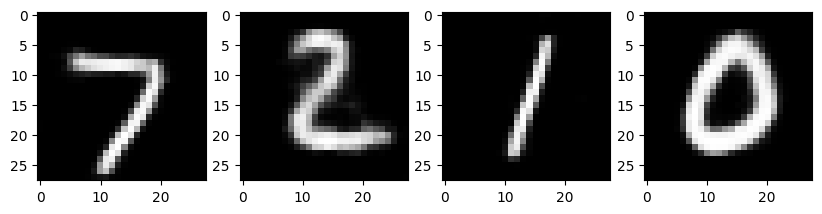

In [19]:
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

plot_samples(x_test)
plot_encoded(encoded)
plot_samples(decoded)

313/313 [==============================] - 2s 7ms/step


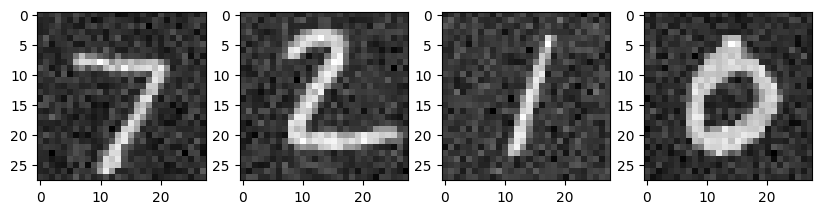

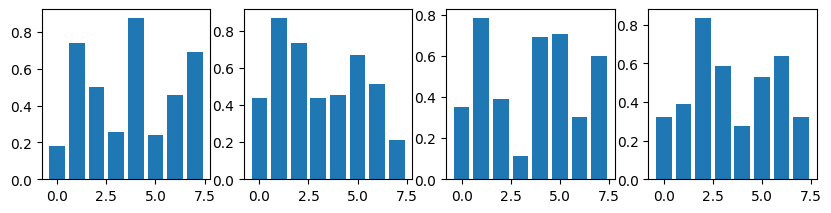

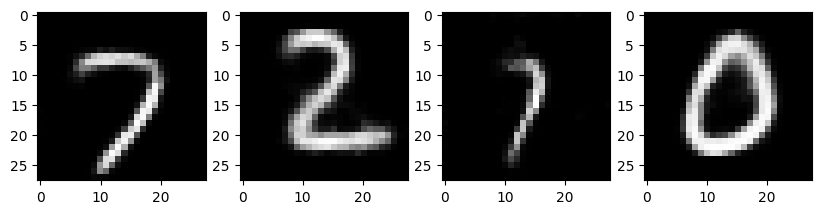

In [20]:
np.random.seed(42)
noise_level = 0.1
noised = (x_test + np.random.normal(scale=noise_level, size=x_test.shape)) / (1.0 + noise_level)
encoded = encoder.predict(noised)
decoded = decoder.predict(encoded)

plot_samples(noised)
plot_encoded(encoded)
plot_samples(decoded)

In [21]:
tsne_enc = TSNE(n_components=2, init='pca')
encoded = encoder.predict(x_test)
pics_tsne_enc = tsne_enc.fit_transform(encoded.reshape((encoded.shape[0], -1)))

313/313 [==============================] - 1s 2ms/step


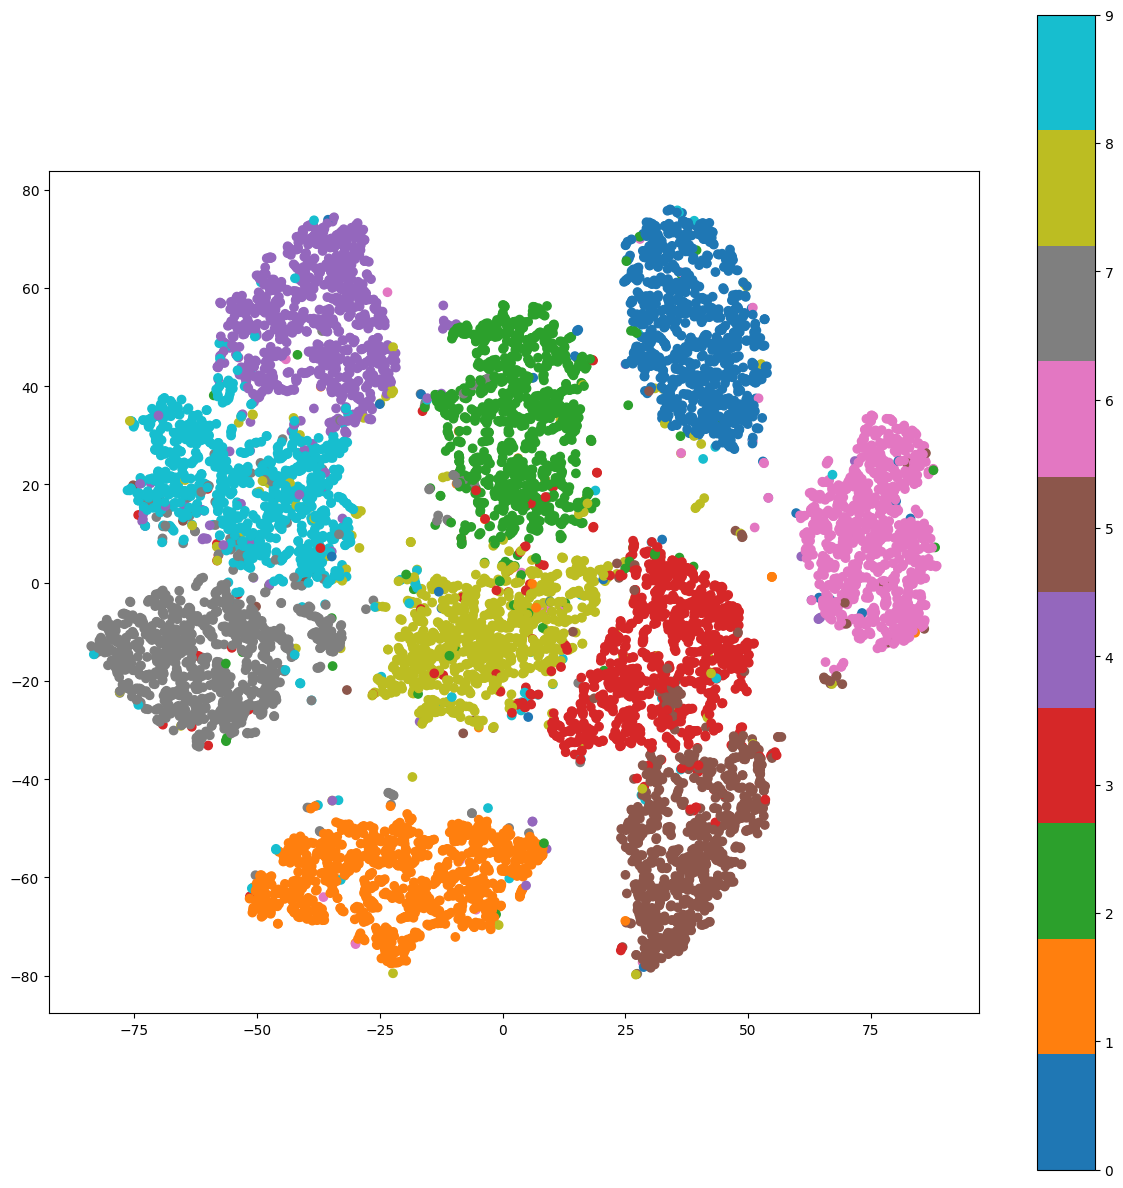

In [22]:
plot_scatter(pics_tsne_enc, y_test)

1/1 [==============================] - 0s 30ms/step


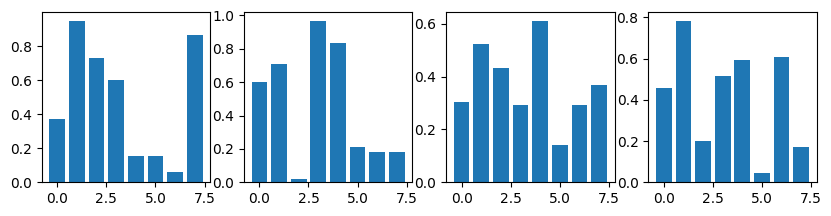

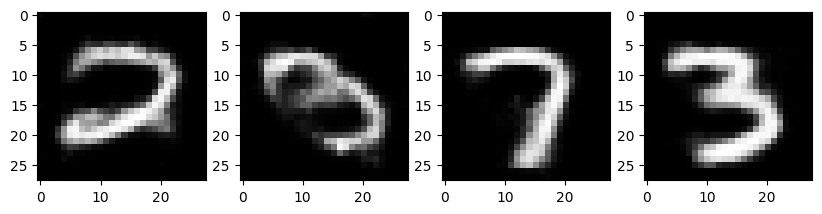

In [23]:
np.random.seed(42)
encoded = np.random.uniform(size=(4, 8))
decoded = decoder.predict(encoded)

plot_encoded(encoded)
plot_samples(decoded)

# Вариационный автокодировщик

In [24]:
INPUT_SHAPE = (28, 28)
HIDDEN1_CH = 24
HIDDEN2_CH = 36
LATENT_DIM = 8

def get_vae_model():
    input_vector = tf.keras.Input(shape=INPUT_SHAPE, name='encoder_input')
    
    encoder = tf.keras.Sequential([
        tf.keras.layers.Reshape((*INPUT_SHAPE, 1)),
        tf.keras.layers.Conv2D(HIDDEN1_CH, (3, 3), strides=(2, 2), activation="relu"),
        tf.keras.layers.Conv2D(HIDDEN2_CH, (3, 3), strides=(2, 2), activation="relu", use_bias=False),
        tf.keras.layers.Conv2D(2 * LATENT_DIM, (6, 6), activation="tanh", use_bias=False),
        tf.keras.layers.Flatten(),
    ])
    
    z_mean, z_log_var = tf.split(encoder(input_vector), num_or_size_splits=2, axis=1)
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
    encoded_vector = z_mean + tf.exp(0.5 * z_log_var) * epsilon    
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Reshape((1, 1, LATENT_DIM)),
        tf.keras.layers.Conv2DTranspose(HIDDEN2_CH, (6, 6), activation="relu", use_bias=False),
        tf.keras.layers.Conv2DTranspose(HIDDEN2_CH, (3, 3), strides=(2, 2), activation="relu", use_bias=False),
        tf.keras.layers.Conv2DTranspose(HIDDEN1_CH, (4, 4), strides=(2, 2), activation="relu", use_bias=False),
        tf.keras.layers.Conv2DTranspose(1, (1, 1), activation="sigmoid", use_bias=False),
        tf.keras.layers.Reshape(INPUT_SHAPE),
    ])
    decoded_vector = decoder(encoded_vector)

    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(input_vector, decoded_vector))
    vae_loss = 0.001 * kl_loss + reconstruction_loss
    
    autoencoder = tf.keras.Model(inputs=[input_vector,], outputs=[decoded_vector,], name="vae")
    autoencoder.add_loss(vae_loss)
    
    encoder_model = tf.keras.Model(inputs=[input_vector,], outputs=[z_mean,])
    
    return autoencoder, encoder_model, decoder

model, encoder, decoder = get_vae_model()

In [25]:
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 16)           28752       ['encoder_input[0][0]']          
                                                                                                  
 tf.split (TFOpLambda)          [(None, 8),          0           ['sequential_2[0][0]']           
                                 (None, 8)]                                                       
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 8)            0           ['tf.split[0][1]']             

In [26]:
learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

fit = model.fit(train_dataset, epochs=25, validation_data=test_dataset)

Epoch 1/25
15000/15000 [==============================] - 79s 5ms/step - loss: 0.0529 - val_loss: 0.0506
Epoch 2/25
15000/15000 [==============================] - 77s 5ms/step - loss: 0.0496 - val_loss: 0.0501
Epoch 3/25
15000/15000 [==============================] - 80s 5ms/step - loss: 0.0491 - val_loss: 0.0496
Epoch 4/25
15000/15000 [==============================] - 76s 5ms/step - loss: 0.0488 - val_loss: 0.0493
Epoch 5/25
15000/15000 [==============================] - 83s 6ms/step - loss: 0.0487 - val_loss: 0.0493
Epoch 6/25
15000/15000 [==============================] - 92s 6ms/step - loss: 0.0486 - val_loss: 0.0494
Epoch 7/25
15000/15000 [==============================] - 80s 5ms/step - loss: 0.0484 - val_loss: 0.0488
Epoch 8/25
15000/15000 [==============================] - 79s 5ms/step - loss: 0.0483 - val_loss: 0.0490
Epoch 9/25
15000/15000 [==============================] - 80s 5ms/step - loss: 0.0483 - val_loss: 0.0488
Epoch 10/25
15000/15000 [==============================

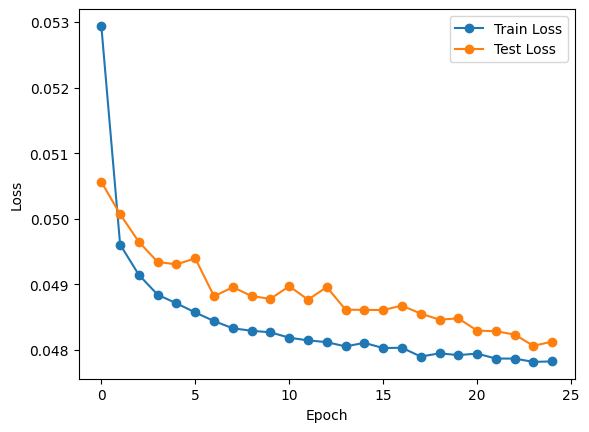

In [27]:
plt.plot(fit.history['loss'], '-o', label="Train Loss")
plt.plot(fit.history['val_loss'], '-o', label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

313/313 [==============================] - 2s 6ms/step


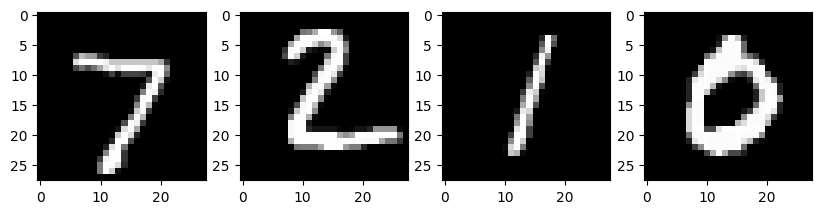

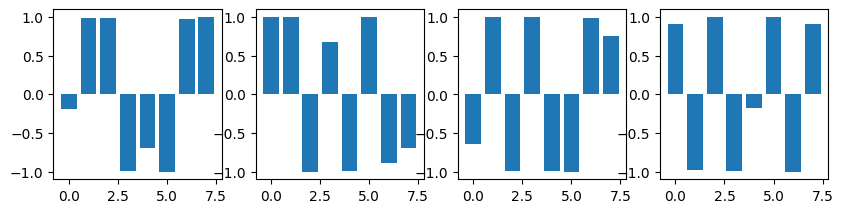

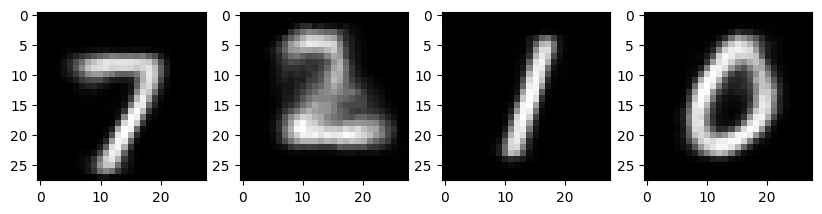

In [28]:
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

plot_samples(x_test)
plot_encoded(encoded)
plot_samples(decoded)

313/313 [==============================] - 2s 6ms/step


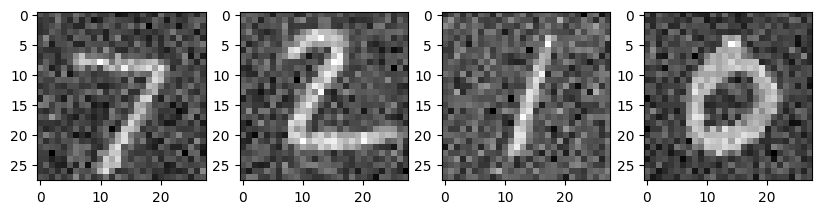

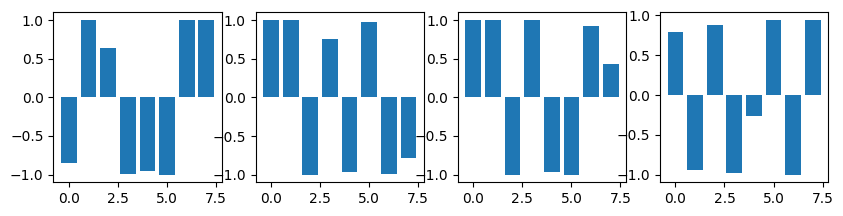

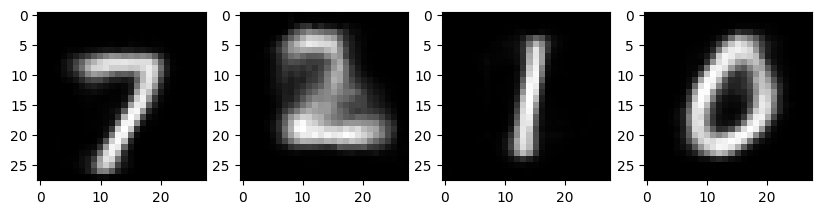

In [29]:
np.random.seed(42)
noise_level = 0.2
noised = (x_test + np.random.normal(scale=noise_level, size=x_test.shape)) / (1.0 + noise_level)
encoded = encoder.predict(noised)
decoded = decoder.predict(encoded)

plot_samples(noised)
plot_encoded(encoded)
plot_samples(decoded)

1/1 [==============================] - 0s 17ms/step


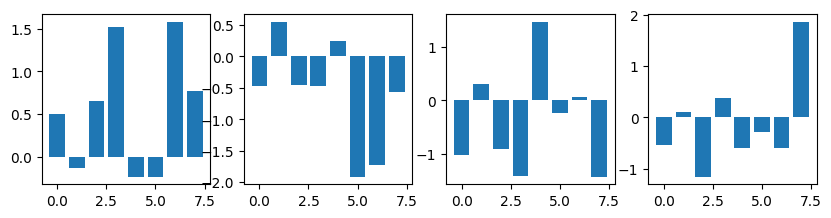

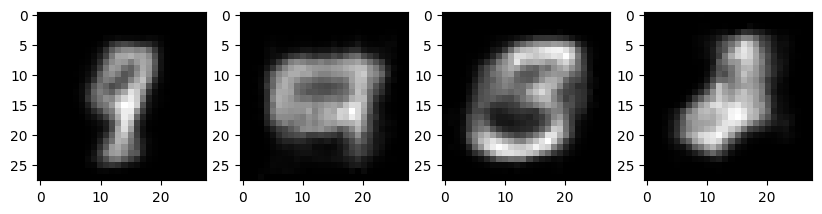

In [30]:
np.random.seed(42)
encoded = np.random.normal(size=(4, 8))
decoded = decoder.predict(encoded)

plot_encoded(encoded)
plot_samples(decoded)